## M6A Analysis Final Part

Put everything else in this notebook.

## Relationship between Gene Expression and M6A level


In [1]:
group_dict = {
    'NH': ['NH_1','NH_2','NH_3','NH_4','NH_5','NH_6','NH_7','NH_8','NH_9','NH_10','NH_11','NH_12',],
    'AH': ['LV_01', 'LV_02', 'LV_03', 'LV_04', 'LV_05', 'LV_06', 'LV_07', 'LV_08','LV_09','LV_10', 'RV_01', 'RV_02', 'RV_03', 'RV_04', 'RV_05', 'RV_06', 'RV_07', 'RV_08','RV_09','RV_10'],
    'NK': ['P1_NKI_1', 'P1_NKI_2', 'P1_NKI_3', 'P1_NKI_4','P1_NKI_5','P1_NKI_6','P1_NKI_7','P1_NKI_8','P1_NKI_9','P1_NKI_10','P1_NKI_11','P1_NKI_12',],
    'AK': ['M_KI_01', 'M_KI_02', 'M_KI_03', 'M_KI_04', 'M_KI_05','F_KI_06', 'F_KI_07', 'F_KI_08', 'F_KI_09', 'F_KI_10',]
}

In [2]:
import pandas as pd
peak_intensity = pd.read_table('../_data/m6A/parsed_peaks/peak_intensity.csv', index_col=0)
peak_to_gene = pd.read_table('../_data/m6A/parsed_peaks/peak_to_gene.txt', index_col=0)
peak_to_gene.index = [x.replace('-', ':') for x in peak_to_gene.index.values]

Compute the average peak intensity for each group

In [3]:
import numpy as np
peak_mean_intes = pd.DataFrame(columns=['NH', 'AH', 'NK', 'AK'], index=peak_intensity.index)
for group in peak_mean_intes.columns.values:
    peak_mean_intes[group] = peak_intensity[group_dict[group]].mean(axis=1)

peak_mean_intes = np.log2(peak_mean_intes)

### Heart Age
Because the gene expression fold-change is computed as AH/NH (see Analysis Part 1: Differential Gene Expression Analysis with DESeq2), we need to keep the order identical when computing for peak fold-change.

In [4]:
gene_expr_foldchange_heart = pd.read_table('../_data/m6A/deseq/Heart_Age.txt')
peak_foldchange_heart = pd.DataFrame(columns=['peak_fc', 'gene', 'gene_fc'], index=peak_mean_intes.index)

In [5]:
peak_foldchange_heart['peak_fc'] = peak_mean_intes['AH'] - peak_mean_intes['NH']
peak_foldchange_heart['gene'] = peak_to_gene.loc[peak_foldchange_heart.index, 'gene']

In [6]:
peak_foldchange_heart['gene_fc'] = [gene_expr_foldchange_heart.loc[x, 'log2FoldChange'] if x in gene_expr_foldchange_heart.index else np.nan 
                              for x in peak_foldchange_heart['gene'] ]

In [7]:
peak_foldchange_heart.head()

,peak_fc,gene,gene_fc
chr12:109612940:109613040,0.053305,ENSMUSG00000097451,NaN
chr12:4880532:4880632,0.441228,ENSMUSG00000020634,1.590420
chr14:75906737:75906837,-0.168853,ENSMUSG00000067995,-0.135701
chr11:86502571:86502671,0.766745,ENSMUSG00000020516,-0.064094
chr11:28576885:28576985,-0.035175,ENSMUSG00000032878,1.046173


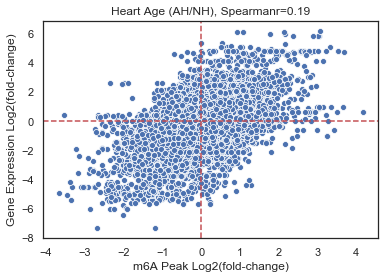

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
corr = ss.spearmanr(peak_foldchange_heart.peak_fc, peak_foldchange_heart.gene_fc, nan_policy='omit').correlation
plt.clf()
sns.set(style="white", color_codes=True)
#ax = sns.jointplot(x=peak_foldchange_heart.peak_fc, y=peak_foldchange_heart.gene_fc, color="skyblue")
ax = sns.scatterplot(x=peak_foldchange_heart.peak_fc, y=peak_foldchange_heart.gene_fc)
ax.axvline(x=0, color='r', linestyle='--')
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('m6A Peak Log2(fold-change)')
ax.set_ylabel('Gene Expression Log2(fold-change)')
ax.set_title('Heart Age (AH/NH), Spearmanr=%.2f'%(corr))
plt.savefig('Heart_Age.pdf')

Manually check a few examples:

In [27]:
tpm = pd.read_table('_data/Average_TPM.txt', index_col=0)
tpm.head()

,gene_symbol,Adult_Kidney,Neonatal_Kidney,Adult_Heart,Neonatal_Heart,gene_description
ENSMUSG00000000001,Gnai3,45.139200,77.950783,9.103968,28.942658,guanine nucleotide binding protein (G protein)...
ENSMUSG00000000003,Pbsn,0.000000,0.000000,0.014959,0.000000,probasin
ENSMUSG00000000028,Cdc45,3.283454,16.880842,2.483566,12.153364,cell division cycle 45
ENSMUSG00000000037,Scml2,0.405706,3.927721,0.475731,4.072922,Scm polycomb group protein like 2
ENSMUSG00000000049,Apoh,2.449987,46.822396,1.723831,4.247798,apolipoprotein H


In [28]:
peak_foldchange_heart.dropna(axis=0, subset=['gene_fc']).sort_values('peak_fc').head(n=15).join(tpm[['Adult_Heart', 'Neonatal_Heart']], on='gene')

,peak_fc,gene,gene_fc,Adult_Heart,Neonatal_Heart
chr1:190949946:190950046,-3.679925,ENSMUSG00000037568,-4.896624,0.306920,16.029931
chr13:45736058:45736158,-3.533344,ENSMUSG00000046876,0.420522,10.994695,14.534452
chr6:128373567:128373667,-3.458341,ENSMUSG00000001517,-5.062161,0.706477,27.451199
chr1:136527243:136527343,-3.384463,ENSMUSG00000041498,-4.197036,0.259176,11.426254
chr15:99082173:99082273,-3.369229,ENSMUSG00000032783,-5.384975,0.139239,10.420802
chr4:115041659:115041759,-3.320843,ENSMUSG00000028718,-4.479159,0.251213,7.366712
chr11:46149355:46149455,-3.240732,ENSMUSG00000020411,-1.928832,0.395764,2.680784
chr12:27341964:27342064,-3.187292,ENSMUSG00000063632,-3.553061,0.242482,5.015710
chr12:70347239:70347339,-3.155010,ENSMUSG00000021071,-2.352098,0.149368,1.306996
chr4:115041559:115041659,-3.107090,ENSMUSG00000028718,-4.479159,0.251213,7.366712


In [29]:
peak_foldchange_heart.dropna(axis=0, subset=['gene_fc']) \
.sort_values('peak_fc', ascending=False) \
.head(n=15) \
.join(tpm[['Adult_Heart', 'Neonatal_Heart']], on='gene')

,peak_fc,gene,gene_fc,Adult_Heart,Neonatal_Heart
chr1:143646700:143646800,4.175082,ENSMUSG00000026361,0.608410,14.052398,16.415180
chr16:30270102:30270202,3.699141,ENSMUSG00000052316,4.738651,7.530572,0.497472
chr1:143646764:143646864,3.667531,ENSMUSG00000033849,0.984774,3.671970,3.297979
chr10:10688059:10688159,3.527312,ENSMUSG00000019828,4.783201,9.398290,0.574594
chr10:10688359:10688459,3.525804,ENSMUSG00000019828,4.783201,9.398290,0.574594
chr1:143646400:143646500,3.512483,ENSMUSG00000026361,0.608410,14.052398,16.415180
chr3:83955355:83955455,3.436751,ENSMUSG00000033767,-0.585286,8.178757,22.199801
chr1:143646464:143646564,3.349324,ENSMUSG00000033849,0.984774,3.671970,3.297979
chr15:77585458:77585558,3.315930,ENSMUSG00000050014,5.113635,4.386321,0.233397
chr14:26919688:26919788,3.266584,ENSMUSG00000040760,-0.012381,9.260612,16.586092


So, it seems the correlation is mostly driven by lowly expressed genes that become expressed in another condition with m6A. We can confirm this by performing the following query:
- Adult Heart TPM > 5 AND
- Neonatal Heart TPM > 5

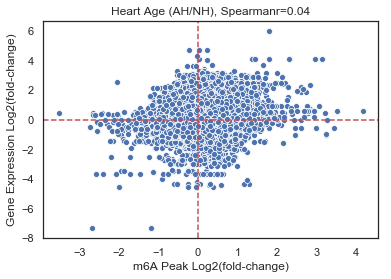

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
peak_foldchange_heart_geneexp = peak_foldchange_heart \
    .join(tpm[['Adult_Heart', 'Neonatal_Heart']], on='gene') \
    .query('Adult_Heart > 5 and Neonatal_Heart > 5')
corr = ss.spearmanr(peak_foldchange_heart_geneexp.peak_fc, peak_foldchange_heart_geneexp.gene_fc, nan_policy='omit').correlation
plt.clf()
sns.set(style="white", color_codes=True)
#sns.jointplot(x=peak_foldchange_heart.peak_fc, y=peak_foldchange_heart.gene_fc, kind='kde', color="skyblue")
ax = sns.scatterplot(x=peak_foldchange_heart_geneexp.peak_fc, y=peak_foldchange_heart_geneexp.gene_fc)
ax.axvline(x=0, color='r', linestyle='--')
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('m6A Peak Log2(fold-change)')
ax.set_ylabel('Gene Expression Log2(fold-change)')
ax.set_title('Heart Age (AH/NH), Spearmanr=%.2f'%(corr))
plt.savefig('Heart_Age_expressed.pdf')

We can, similarly, plot the distribution of gene expression TPMs within a sample by separating genes into m6A-marked and not m6A-marked. This is also confounded by the detection power for m6A sites: highly expressed genes are easier to find m6A, while lowly-expressed are not. 

Text(0,0.5,'Density')

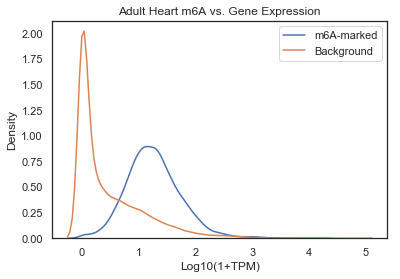

In [14]:
# get the genes with m6A marks
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

genes_with_peak_LV = [x.rstrip(':[+-]').replace('-', ':') for x in pd.read_table('../20181019-m6A-3/_data/LV.peaks.tsv',index_col=0)['gene']]
#print(genes_with_peak_LV[0:5])
genes_with_peak_RV = [x.rstrip(':[+-]').replace('-', ':') for x in pd.read_table('../20181019-m6A-3/_data/RV.peaks.tsv',index_col=0)['gene']]
genes_with_peak = set(genes_with_peak_LV + genes_with_peak_RV)
tpm = pd.read_table('_data/Average_TPM.txt', index_col=0)

geneExp_m6A = [np.log10(1+tpm.loc[x, 'Adult_Heart']) for x in tpm.index if x in genes_with_peak]
geneExp_bg = [np.log10(1+tpm.loc[x, 'Adult_Heart']) for x in tpm.index if x not in genes_with_peak]

plt.clf()
ax = sns.distplot(geneExp_m6A, hist=False, rug=False, label='m6A-marked')
sns.distplot(geneExp_bg, hist=False, rug=False, label='Background', ax=ax)
ax.set_title('Adult Heart m6A vs. Gene Expression')
ax.set_xlabel('Log10(1+TPM)')
ax.set_ylabel('Density')

### Kidney Age
Now do the same thing for Kidney Age. Note that Kidney gene expression fold-change is computed as Adult Kidney / Neonatal Kidney.

In [36]:
gene_expr_foldchange_kidney = pd.read_table('../_data/m6A/deseq/Kidney_Age.txt')
peak_foldchange_kidney = pd.DataFrame(columns=['peak_fc', 'gene', 'gene_fc'], index=peak_mean_intes.index)
peak_foldchange_kidney['peak_fc'] = peak_mean_intes['AK'] - peak_mean_intes['NK']
peak_foldchange_kidney['gene'] = peak_to_gene.loc[peak_foldchange_kidney.index, 'gene']
peak_foldchange_kidney['gene_fc'] = [gene_expr_foldchange_kidney.loc[x, 'log2FoldChange'] if x in gene_expr_foldchange_kidney.index else np.nan 
                              for x in peak_foldchange_kidney['gene'] ]

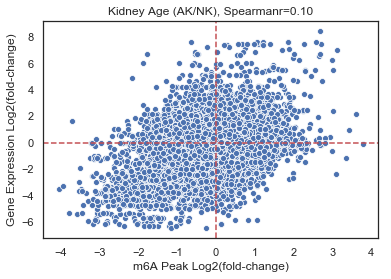

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
corr = ss.spearmanr(peak_foldchange_kidney.peak_fc, peak_foldchange_kidney.gene_fc, nan_policy='omit').correlation
plt.clf()
sns.set(style="white", color_codes=True)
#sns.jointplot(x=peak_foldchange.peak_fc, y=peak_foldchange.gene_fc, kind='kde', color="skyblue")
ax = sns.scatterplot(x=peak_foldchange_kidney.peak_fc, y=peak_foldchange_kidney.gene_fc)
ax.axvline(x=0, color='r', linestyle='--')
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('m6A Peak Log2(fold-change)')
ax.set_ylabel('Gene Expression Log2(fold-change)')
ax.set_title('Kidney Age (AK/NK), Spearmanr=%.2f'%(corr))
plt.savefig('Kidney_Age.pdf')

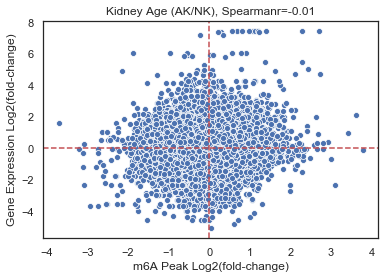

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
peak_foldchange_kidney_geneexp = peak_foldchange_kidney \
    .join(tpm[['Adult_Kidney', 'Neonatal_Kidney']], on='gene') \
    .query('Adult_Kidney > 5 and Neonatal_Kidney > 5')
corr = ss.spearmanr(peak_foldchange_kidney_geneexp.peak_fc, peak_foldchange_kidney_geneexp.gene_fc, nan_policy='omit').correlation
plt.clf()
sns.set(style="white", color_codes=True)
#sns.jointplot(x=peak_foldchange.peak_fc, y=peak_foldchange.gene_fc, kind='kde', color="skyblue")
ax = sns.scatterplot(x=peak_foldchange_kidney_geneexp.peak_fc, y=peak_foldchange_kidney_geneexp.gene_fc)
ax.axvline(x=0, color='r', linestyle='--')
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('m6A Peak Log2(fold-change)')
ax.set_ylabel('Gene Expression Log2(fold-change)')
ax.set_title('Kidney Age (AK/NK), Spearmanr=%.2f'%(corr))
plt.savefig('Kidney_Age_expressed.pdf')

### Adult Heart vs Adult Kidney
The comparison on Gene expression was done in the order of AH vs AK.

In [11]:
gene_expr_foldchange_ahk = pd.read_table('../_data/m6A/deseq/AHK.txt')
peak_foldchange_ahk = pd.DataFrame(columns=['peak_fc', 'gene', 'gene_fc'], index=peak_mean_intes.index)
peak_foldchange_ahk['peak_fc'] = peak_mean_intes['AH'] - peak_mean_intes['AK']
peak_foldchange_ahk['gene'] = peak_to_gene.loc[peak_foldchange_ahk.index, 'gene']
peak_foldchange_ahk['gene_fc'] = [gene_expr_foldchange_ahk.loc[x, 'log2FoldChange'] if x in gene_expr_foldchange_ahk.index else np.nan 
                              for x in peak_foldchange_ahk['gene'] ]

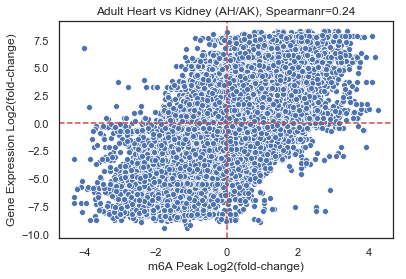

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
corr = ss.spearmanr(peak_foldchange_ahk.peak_fc, peak_foldchange_ahk.gene_fc, nan_policy='omit').correlation
plt.clf()
sns.set(style="white", color_codes=True)
ax = sns.scatterplot(x=peak_foldchange_ahk.peak_fc, y=peak_foldchange_ahk.gene_fc)
ax.axvline(x=0, color='r', linestyle='--')
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('m6A Peak Log2(fold-change)')
ax.set_ylabel('Gene Expression Log2(fold-change)')
ax.set_title('Adult Heart vs Kidney (AH/AK), Spearmanr=%.2f'%(corr))
plt.savefig('AHK.pdf')

### Neonatal Heart vs Neonatal Kidney
The comparison on Gene expression was done in the order of NH vs NK.

In [13]:
gene_expr_foldchange_nhk = pd.read_table('../_data/m6A/deseq/NHK.txt')
peak_foldchange_nhk = pd.DataFrame(columns=['peak_fc', 'gene', 'gene_fc'], index=peak_mean_intes.index)
peak_foldchange_nhk['peak_fc'] = peak_mean_intes['NH'] - peak_mean_intes['NK']
peak_foldchange_nhk['gene'] = peak_to_gene.loc[peak_foldchange_nhk.index, 'gene']
peak_foldchange_nhk['gene_fc'] = [gene_expr_foldchange_nhk.loc[x, 'log2FoldChange'] if x in gene_expr_foldchange_nhk.index else np.nan 
                              for x in peak_foldchange_nhk['gene'] ]

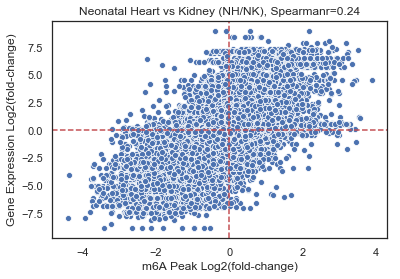

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
corr = ss.spearmanr(peak_foldchange_nhk.peak_fc, peak_foldchange_nhk.gene_fc, nan_policy='omit').correlation
plt.clf()
sns.set(style="white", color_codes=True)
ax = sns.scatterplot(x=peak_foldchange_nhk.peak_fc, y=peak_foldchange_nhk.gene_fc)
ax.axvline(x=0, color='r', linestyle='--')
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('m6A Peak Log2(fold-change)')
ax.set_ylabel('Gene Expression Log2(fold-change)')
ax.set_title('Neonatal Heart vs Kidney (NH/NK), Spearmanr=%.2f'%(corr))
plt.savefig('NHK.pdf')